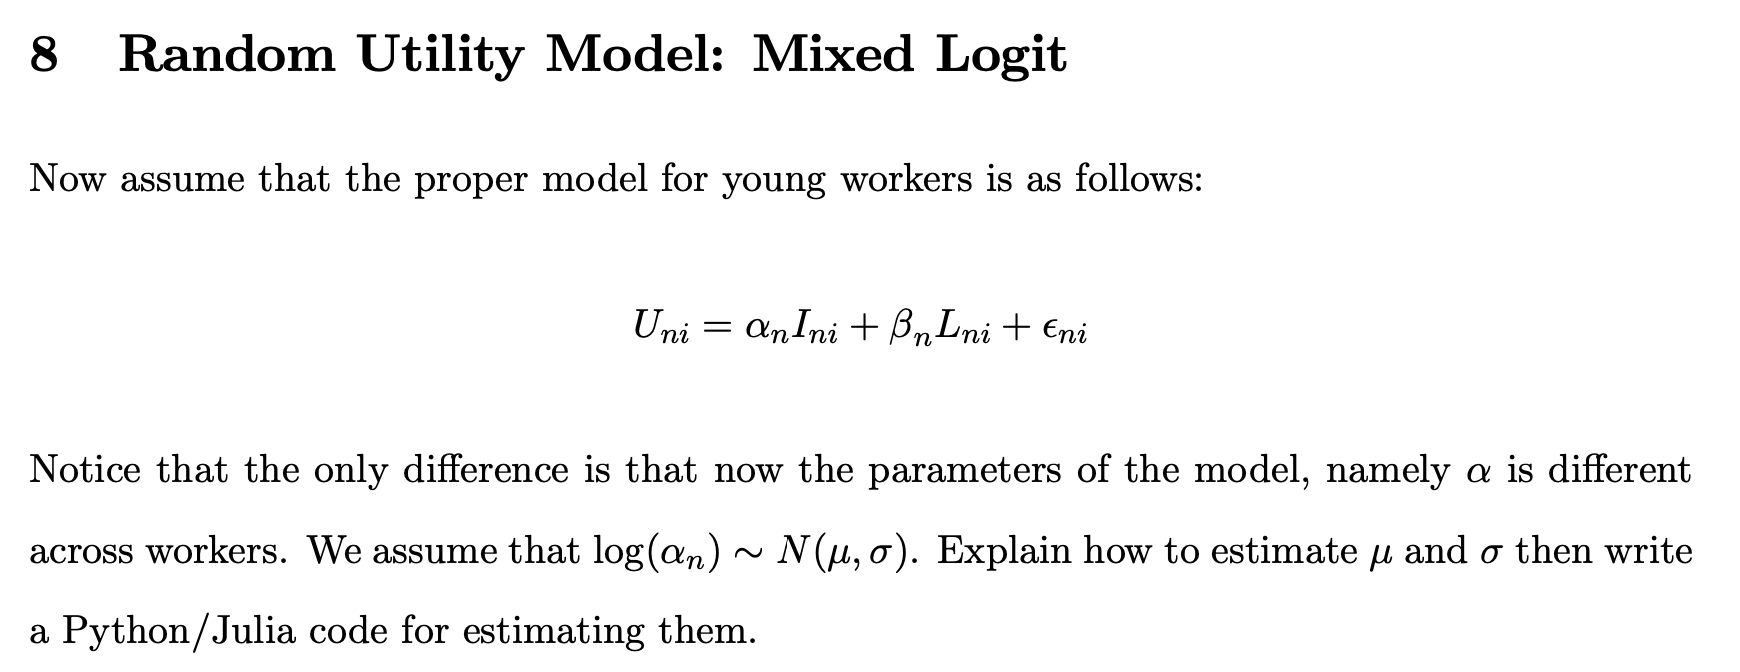

- In the data generation, we should sample a random $\alpha$ for each worker.
- Here we have logit instead of probit, so the conditional choice probability (given $\alpha$) can be calculated without simulation, with the logit formula.
- However, as the $\alpha$ for each worker is not observed, we should calculate the unconditional choice probability with simulation.
- Finally, we can use MSLE to estimate the parameters.

In [1]:
import numpy as np
from scipy.optimize import minimize

In [2]:
%%time
N = 10_000
M = 2
sigma = 1  # σ
mu = 0
z = 12
h = 1  # Shirkhodaee

np.random.seed(1395)
epsilon = np.random.normal(0, sigma, (N, M))
wage_offers = np.random.exponential(1 / 0.2, size=(N, 1))
I = np.hstack([np.ones((N, 1)) * z, wage_offers * h])
alpha = np.exp(np.random.normal(mu, sigma, size=(N, 1)))
U = alpha * I + 0 + epsilon
accept = U[:, 1] > U[:, 0]

CPU times: user 2.49 ms, sys: 1.58 ms, total: 4.07 ms
Wall time: 2.13 ms


In [3]:
%%time
R = 500
RANDOM_NORMAL_1 = np.random.normal(0, 1, size=(N, R))

def conditional_p(alpha, I, sigma):
    T = alpha * (I[:, [0]] - I[:, [1]])
    T = T * (np.pi / 3**0.5) / (sigma * 2**0.5) # IMPORTANT
    T[T < -20] = -20
    T[T > 20] = 20
    T = 1 / (np.exp(T) + 1)
    return T


def unconditional_p(mu, sigma, I, R, N):
    # alpha = np.exp(np.random.normal(mu, sigma, size=(N, R)))
    # IMPORTANT: this change, decreased execution time by more than 90 precent!
    alpha = np.exp(mu + sigma * RANDOM_NORMAL_1)
    return conditional_p(alpha, I, sigma).mean(1)


def sll(theta, accept, I, R, N):
    sp = unconditional_p(mu=theta[0], sigma=theta[1], I=I, R=R, N=N)
    return - (accept @ np.log(sp) + (1 - accept) @ np.log(1 - sp)).item()

CPU times: user 138 ms, sys: 10.8 ms, total: 149 ms
Wall time: 147 ms


In [4]:
%%time
theta0 = np.array([0.2, 0.8])
result = minimize(sll, theta0, args=(accept, I, R, N),
                  bounds=[(-0.5, 0.5), (0.5, 1.5)], method='Nelder-Mead')
print(result.x)

[-0.04244902  0.9915603 ]
CPU times: user 11.5 s, sys: 1.18 s, total: 12.6 s
Wall time: 12.6 s


- The estimated $\mu$ (-0.0424) is near the true $\mu$ (0.0)
- The estimated $\sigma$ (0.9915) is near the true $\sigma$ (1.0)